# Micro Experiments

This notebook exists so that I can run a whole bunch of small experiments suggested by various people throughout the months (recorded in my physical notebooks). In particlar, I plan to test:

  - Coarse vs Fine grained compression
  - Time-angle repacking
  - Two-half comparison
  - Time-reversed comparison
  - Frame delta compression
  - (Position, bindelta) compression (but I need to find a reference frame first)
  - Molecule duplication
  - If possible, matrix-based compression techniques.
  - Time-reversed copy compression (??) \[variant on time-reversed\]
  
Let's get coding!

In [1]:
import os, tempfile, subprocess, pickle
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
from compressstate_ic import *
from runCompressMD import *

### Data Import

Import data for use. Because MDTraj likes to spend tens of GB and minutes reading in data, this data has 
already been read in (via the functions in runCompressMD) and then pickled. This shortens the processing time.
However, it still requires 10s of GB to hold the trajectories in memory. Since we don't need any more than every
100th frame or so, we discard the extraneous frames to stop our computer from hitting OOM (which my 64GB desktop already does about halfway through).

We also bind some extra names to these things to make them easier to access.

In [2]:
rawdesrestrajectory = pickle.load(open("/home/chipbuster/tmp/jupytermicro/mdtraj-pickled.pkl","rb"))
print("Trajectory has " + str(len(rawdesrestrajectory)) + " frames")

trajectory = rawdesrestrajectory[::50]
del rawdesrestrajectory

allnames = ['dres','1lmb','1prs','1pnj','2a3d']
alltrajs = [trajectory, 
            pickle.load(open('/home/chipbuster/tmp/jupytermicro/1lmb-pickled.pkl','rb'))[::50],
            pickle.load(open('/home/chipbuster/tmp/jupytermicro/1prs-pickled.pkl','rb'))[::50],
            pickle.load(open('/home/chipbuster/tmp/jupytermicro/1pnj-pickled.pkl','rb'))[::50],
            pickle.load(open('/home/chipbuster/tmp/jupytermicro/2a3d-pickled.pkl','rb'))[::50]
           ]
desmond_names = allnames[1:]
desmond_trajs = alltrajs[1:]
traj_1lmb = alltrajs[1]
traj_1prs = alltrajs[2]
traj_1pnj = alltrajs[3]
traj_2a3d = alltrajs[4]

# Default settings from paper
numStates = 11
baseSkip = 2 #100 frames, after accounting for input skips

Trajectory has 1987500 frames


### Coarse Vs Fine

Compressing every other frame should give us similar results to compressing every frame. If it does not, this technique smells like bullshit.

To test this, we use the Piana benchmarks (specifically, pnas2012-1yrf-WT-345K), since this is a test of the technique more than the trajectories.

In [3]:
# Check compression on the full instance with variable skips. Start at default of 100 (paper value) max at 100k
# Since we already skip 50 frames on input, 100 = 2, and 100,000 = 2000
ratios = []
for skip in np.arange(2,2000,1):
    testtraj = trajectory[::skip]
    c = CompressionData(testtraj,numStates)
    ratio = c.get_compression_ratios()
    ratios.append((skip,ratio))

# Print block in case printed values are wanted
#print("Skip-ratio values:" )
#for (s,r) in ratios:
#    print("%d\t%f"%(s*50,r))

Ratio ≈ 0.016476 * skip + 0.132910


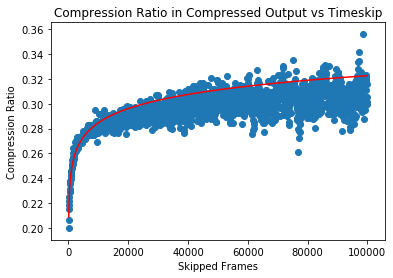

In [4]:
# Plot data against a hand-fitted line
# Autocorrelation ratio roughly rises as the log of the gap
(x,y) = zip(*ratios)
x = np.array([ z*50 for z in x ])  # Rescale to actual skip values
(A,B) = np.polyfit(np.log(x[:200]),y[:200],1)
plt.plot(x,A*np.log(np.array(x)) + B,color='red')
plt.scatter(x,y)
print("Ratio ≈ %f * skip + %f" %(A,B))
plt.title("Compression Ratio in Compressed Output vs Timeskip")
plt.xlabel("Skipped Frames")
plt.ylabel("Compression Ratio")
plt.show()

Ratio ≈ 0.016476 * skip + 0.132910


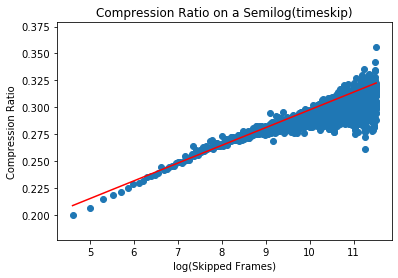

In [5]:
# Plot same values on a semilog plot
(x,y) = zip(*ratios)
x = np.array([ z*50 for z in x ])  # Rescale to actual skip value
(A,B) = np.polyfit(np.log(x[:200]),y[:200],1)
plt.scatter(np.log(x),y)
plt.plot(np.log(x), A * np.log(x) + B,color='red')
plt.title("Compression Ratio on a Semilog(timeskip)")
print("Ratio ≈ %f * skip + %f" %(A,B))
plt.xlabel("log(Skipped Frames)")
plt.ylabel("Compression Ratio")
plt.show()

(1987500, 68)


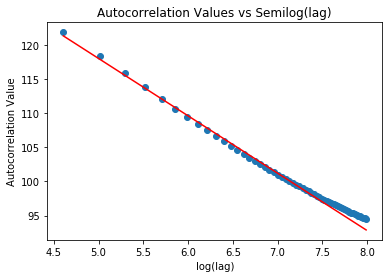

In [6]:
# Check autocorrelation of trace

# We need the raw trajectory for this experiment.

rawdesrestrajectory = pickle.load(open("/home/chipbuster/tmp/jupytermicro/mdtraj-pickled.pkl","rb"))

from numba import jit

import extraction

iangletrace = extraction.convert_IC(rawdesrestrajectory)

print(np.shape(iangletrace))

test_tau_values = np.arange(100,3000,50)
autocorr = np.empty(np.size(test_tau_values))

# Compute autocorrelation via https://en.wikipedia.org/wiki/Autocorrelation#Auto-correlation_of_stochastic_processes
# R_{xx}(\tau) = \E [<X_{t+\tau}, X_t>]. Since the X_i are all real, this 
# corresponds to a simple inner product
@jit
def compute_autocorr(iatrace, lag):
#    print("computing " + str(lag))
    (num_frames,num_angles) = np.shape(iatrace)
    num_samples = num_frames - lag
    autocorr = 0.0
    for i in range(num_samples):                                                                                                                                                                                                             
        autocorr += np.dot(iatrace[i,:], iatrace[i + lag,:])
    autocorr /= num_samples
    return autocorr

for index in range(np.size(test_tau_values)):
    tau = test_tau_values[index]
    autocorr[index] = compute_autocorr(iangletrace, tau)

tau = np.arange(0,3000,1)

taus = []
corrs = []
for (i, corr) in enumerate(autocorr):
    taus.append(test_tau_values[i]);
    corrs.append(corr)

# Autocorrelation is roughly exponential falloff with skip
plt.scatter(np.log(taus),corrs)
plt.title("Autocorrelation Values vs Semilog(lag)")
plt.plot(np.log(taus), -8.4*np.log(taus) + 160,color='red')
plt.xlabel("log(lag)")
plt.ylabel("Autocorrelation Value")
plt.show()

del rawdesrestrajectory

Conclusion 

It's surprisingly tricky to get a "stable" value for the frameskip, since the convergence is roughly logarithmic (as expected). Clearly it should asymptote at some real value, yet what this value is is unclear.

Two notes about these plots: first, the noise increases with frameskip because we are compressing fewer and fewer frames (with only 19 frames being compressed on the far RHS of the first plot). Second, because the compression ratio nominally upper-bounds the true entropy, we *may* have a candidate for an asymptote, roughly 0.28, or the bottom of the uncertain region.

Question: Does this also hold for the Ising Model entropies (where we know the actual values?)

### Time-Angle repacking

In principle, we should be able to repack the current representation of time-angle snapshots into one of angle-time traces (i.e. instead of snapshots of all angles at one time, repack into sequential streams, each representing all of one angle). Avinery et. al. actually report having done this and having gotten slightly better entropies from one vs the other.

In [7]:
# Generate repackings
numBins = 11
skips = 200 // 50      # Modify by already-skipped frames
winSize = 2000 // 50   # same

normal = {}
transposed = {}

for start in np.arange(0,len(trajectory)-winSize,winSize):
    c0 = CompressionData(trajectory[start:start+winSize:skips],numBins)
    cT = CompressionData(trajectory[start:start+winSize:skips],numBins)
    cT.frames = cT.frames.T
    cT.binned = cT.binned.T
    normal[start*50] = c0.get_compression_ratios()
    transposed[start*50] = cT.get_compression_ratios()

Text(0.5, 1.0, 'Normal is [c1, c2, c3...] @ time while transposed is [t1, t2, t3] for coord')

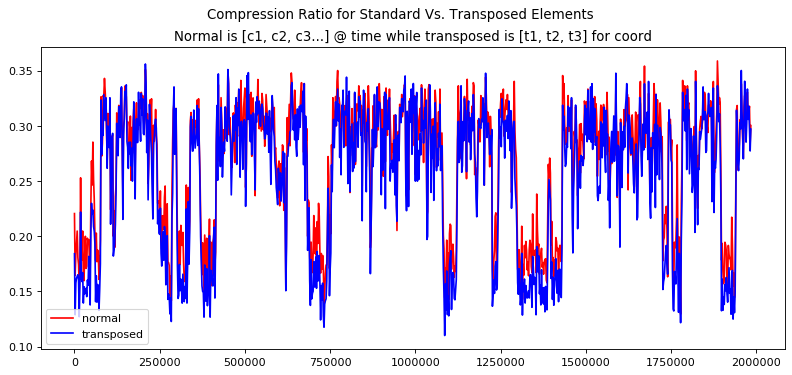

In [8]:
plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(normal.keys()),list(normal.values()),color='r',label="normal")
plt.plot(list(transposed.keys()),list(transposed.values()),color='b',label="transposed")
plt.legend()
plt.suptitle("Compression Ratio for Standard Vs. Transposed Elements")
plt.title("Normal is [c1, c2, c3...] @ time while transposed is [t1, t2, t3] for coord")

###### Conclusion

Transposed provides slightly superior compression, interestingly, mostly in regions of low entropy.

One possible explanation: in low-entropy periods, angles do not change much, and so the lookbehind window can be much larger. If we are packing angles in the fast-changing coordinate, then a few jittered angles can destroy compressibility, while they are confined to one or two subarrays in time-in-fast-changing.

N.B.: This makes assumptions about the capabilities of the lookbehind window: in a perfect world, of course, both are the same. One way to test this is to see if both DEFLATE and LZMA have the same issue (because they use similar backreferencing algorithms), while another would be to encode as <offset index, offset amount> pairs, which should eliminate any backreferencing.

### Two-half comparison

It should be the case that, on average, if we compress two sufficiently large segments of the trace, we should get similar results. Try first half/last half separated by a gap.

This is a test of both technique and trace, so we need to import a few other traces from our smaller batch tests.

In [9]:
def two_traj_halves(traj):
    last = len(traj)
    mid = last//2
    return(traj[:mid], traj[mid:])

print("name: Ratio1  Ratio2  %Difference")
for name,test_t in zip(desmond_names,desmond_trajs):
    first,last = two_traj_halves(test_t)
    c1 = CompressionData(first, 11)
    c2 = CompressionData(last, 11)
    r1 = c1.get_compression_ratios()
    r2 = c2.get_compression_ratios()
    print("%s: %.6f  %.6f  %2.6f" % (name, r1, r2, abs(r2-r1)*100/r1))

name: Ratio1  Ratio2  %Difference
1lmb: 0.299057  0.294772  1.432828
1prs: 0.109911  0.104783  4.665119
1pnj: 0.155012  0.161914  4.452711
2a3d: 0.109943  0.106540  3.094892


In [10]:
# Let's try this with the DESRES trajectory as well
quad = len(trajectory)//4
subtraj = (trajectory[0:quad:baseSkip],
           trajectory[quad:2*quad:baseSkip], 
           trajectory[2*quad:3*quad:baseSkip], 
           trajectory[3*quad::baseSkip])
print("Ratio1  Ratio2  %Difference")
for test_t in subtraj:
    c1 = CompressionData(test_t, 11)
    r1 = c1.get_compression_ratios()
    print("%.6f" % (r1))

Ratio1  Ratio2  %Difference
0.187874
0.232301
0.202395
0.214688


###### Conclusion

The difference exists, but is fairly small (on the order of 5-10%). This does not appear to be particularly symptomatic of burn-in differences in the Desmond-generated trajectories.

The Piana trajectories have higher variance, but we know they exhibit long periods of folded-unfolded behavior.

### Time-reversed compression

Another invariant is that compression of a time-reversed trajectory should give the same result as compression of a time-forward trajectory.

Unfortunately, the base classes were not designed to deal with this, so I'm going to have to get a little creative in destroying the langauge abstractions to get this to work.

In [11]:
class ReverseCompressionData(CompressionData):
    def __init__(self,univ,bincount):
        self.dtype = self.calc_min_data_type(bincount)

        allframes = np.flipud(extraction.convert_IC(univ))
        
        self.frames = np.array([x for x in allframes])
        self.binned = np.digitize(self.frames,
                                  np.linspace(-180,180,num=bincount),
                                  right=True)
        self.ndof = np.size(self.frames[0])                                                                           
        self.bincount = bincount

        self.cachedCd = None
        self.cachedC0 = None
        self.cachedC1 = None

In [12]:
# Check time-reversed compressibility
print("name\tforward\t\tbackward\t%Diff")
for (name, traj) in zip(allnames, alltrajs):
    fc = CompressionData(traj[::baseSkip],numStates)
    rc = ReverseCompressionData(traj[::baseSkip],numStates)
    fr = fc.get_compression_ratios()
    rr = rc.get_compression_ratios()
    print("%s:\t%.6f\t%.6f\t%2.6f"%(name, fr,rr, abs(fr-rr)*100 / fr))

name	forward		backward	%Diff
dres:	0.197257	0.201588	2.195941
1lmb:	0.304524	0.302973	0.509481
1prs:	0.113092	0.112181	0.805533
1pnj:	0.158340	0.167948	6.067961
2a3d:	0.113235	0.111833	1.237989


###### Conclusion

This works roughly as-expected, with generally smaller deltas than seen in the two-halves experiment.
One thing to test would be whether getting two copies (one time-reverse and one not) changes things or not.
However, that's slightly outside the scope of what I want to do right now.

### Framedelta compression

An alternate representation that I don't expect to work particularly well. However, if we have a large portion of zeros in the deltas (i.e. a slow-changing state), maybe it's easier for the backreferencing window to find zero patterns. I expect this to be *extremely* similar to the naive algorithm, since this is just a shifted (i.e. rebinined) version of the main algorithm.

In [13]:
class DeltaCompressionData(CompressionData):
    def __init__(self,univ,bincount):
        self.dtype = self.calc_min_data_type(bincount)

        frames = extraction.convert_IC(univ)
        deltas = np.diff(frames,n=1,axis=0)

        self.frames = np.array([x for x in deltas])
        self.binned = np.digitize(self.frames,
                                  np.linspace(-180,180,num=bincount),
                                  right=True)
        self.ndof = np.size(self.frames[0])                                                                           
        self.bincount = bincount

        self.cachedCd = None
        self.cachedC0 = None
        self.cachedC1 = None
        
class DeltaInitCompressionData(CompressionData):
    def __init__(self,univ,bincount):
        self.dtype = self.calc_min_data_type(bincount)

        frames = extraction.convert_IC(univ)
        deltas = np.diff(frames,n=1,axis=0)
        deltas = np.vstack((deltas, frames[0,:]))

        self.frames = np.array([x for x in deltas])
        self.binned = np.digitize(self.frames,
                                  np.linspace(-180,180,num=bincount),
                                  right=True)
        self.ndof = np.size(self.frames[0])                                                                           
        self.bincount = bincount

        self.cachedCd = None
        self.cachedC0 = None
        self.cachedC1 = None

In [14]:
print("name\tbase\t\tdelta\t\tdeltainit")
for (name, traj) in zip(allnames, alltrajs):
    cc = CompressionData(traj[::baseSkip],numStates)
    dc = DeltaCompressionData(traj[::baseSkip],numStates)
    ic = DeltaInitCompressionData(traj[::baseSkip],numStates)
    cr = cc.get_compression_ratios()
    dr = dc.get_compression_ratios()
    ir = ic.get_compression_ratios()
    print("%s:\t%.6f\t%.6f\t%2.6f"%(name, cr,dr,ir))

name	base		delta		deltainit
dres:	0.199684	0.377187	0.373834
1lmb:	0.302894	0.409737	0.409867
1prs:	0.113081	0.397209	0.399726
1pnj:	0.157975	0.397754	0.397893
2a3d:	0.113235	0.396741	0.395775


###### Conclusion

....alright, the fuck is this? Maybe something to do with the size of the base data used for comparison?

### (Position, bindelta)

Encode the protein as a series of (position, bindelta) tuples. This can conceptually be teased apart into two streams. The advantage here is that there is no longer any spatially local data, i.e. in theory this can be perfectly captured by an entropy coder.

For reference position, use the mode of each position. This is not strictly physical, but we're working in an information-theoretic setting, so what do we care?

Questions: what should I use as the base data size for $C_d$ and $C_0$?

Answer 1: random data with the same size as all the deltas. This will most likely require writing a custom compressor class, since the standard one assumes a square grid.

Answer 2: ????

In [69]:
ntraj = CompressionData(trajectory[::4],11)
ctraj = PBDCompressionData(trajectory[::4],11)

ctraj.testfunc()

print(ntraj.get_compression_ratios())
print(ctraj.get_compression_ratios())

(68,)
(68,)
(68,)
14
66
276
0.2127943247093615
[[   737 123893    276]
 [   172    172     14]
 [523017 675690     68]]
0.10392709716233998
